In [21]:
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import sklearn as sk
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
from skimage import io
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
import tensorflow.keras.optimizers as optim
from tensorflow.keras import preprocessing as pp
from tensorflow.keras import callbacks as cb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

tf.__version__

'2.3.0'

In [2]:
batch_size = 32
img_size = 224
seed=42
root_dir = "C:\\Users\\tymon\\Documents\\treino\\pelagem\\imagens"

In [3]:
train_datagen = pp.image.ImageDataGenerator(rescale=1./255.,
                                            validation_split=0.2,
                                            featurewise_std_normalization=False,
                                            rotation_range=20,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            horizontal_flip=True,
                                            vertical_flip=False,
                                            brightness_range=[0.8,1.2]
                                            )

valid_datagen = pp.image.ImageDataGenerator(rescale=1./255, 
                                            validation_split=0.2,
                                            featurewise_std_normalization=False)



valid_gen = valid_datagen.flow_from_directory(root_dir, subset='validation',\
                                              shuffle=True, seed=seed, 
                                              target_size=(img_size,img_size),\
                                              batch_size=batch_size, color_mode='rgb')

train_gen = train_datagen.flow_from_directory(root_dir, subset='training',\
                          shuffle=True, seed=seed, target_size=(img_size,img_size),\
                          batch_size=batch_size, color_mode='rgb')

Found 871 images belonging to 9 classes.
Found 3505 images belonging to 9 classes.


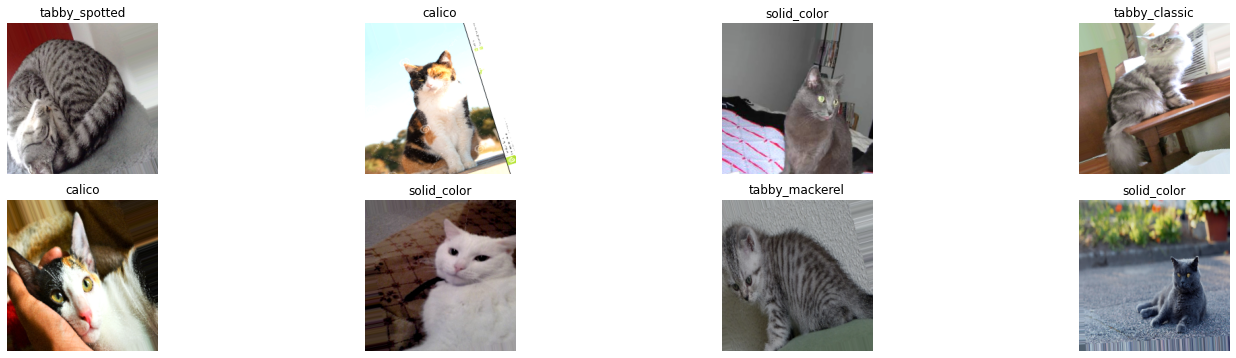

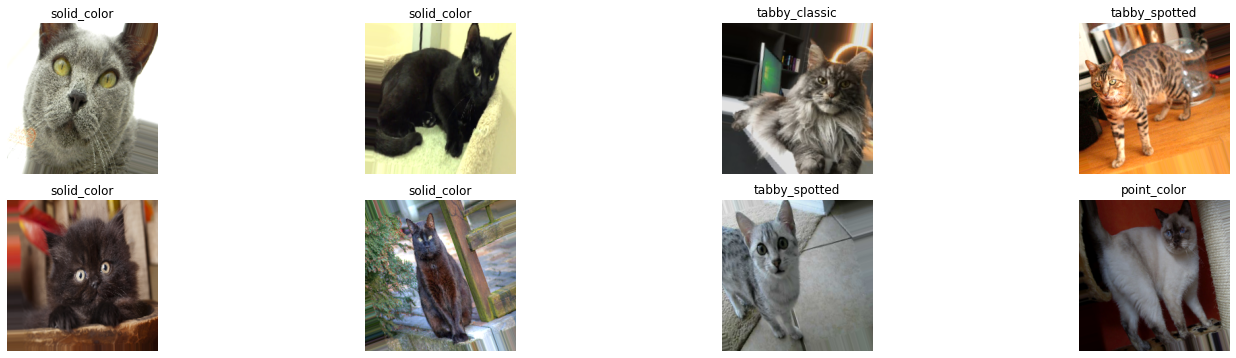

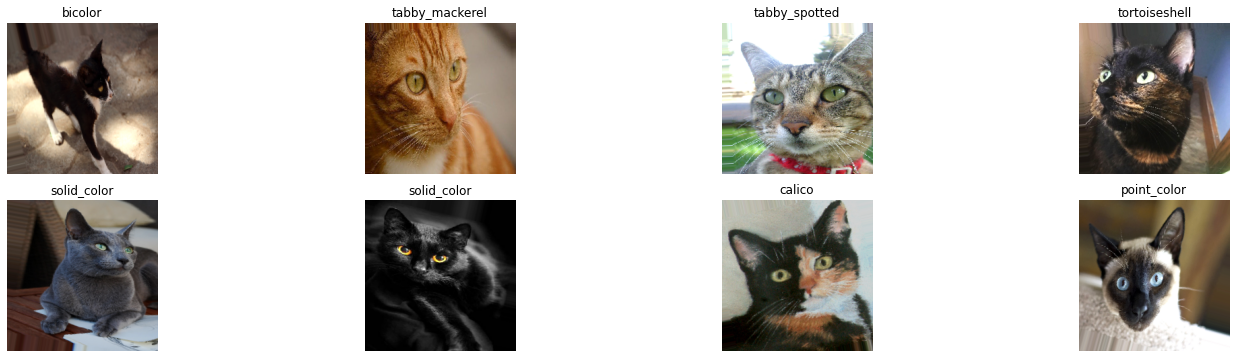

In [4]:
def decode(label): #Função para decodificar os labels 
    nomes = ['bicolor',
             'calico',
             'hairless',
             'point_color',
             'solid_color',
             'tabby_classic',
             'tabby_mackerel',
             'tabby_spotted',
             'tortoiseshell']
    return nomes[np.argmax(label)]

# mostrar as imagens
def show_batch(images_, labels_):
    plt.figure(figsize=(20,10))
    for n in range(8):
        label = [x for x in labels_]
        image = [x for x in images_]
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image[n])
        plt.title(decode(label[n]))
        plt.axis('off')
        plt.tight_layout()
images_, labels_ = train_gen[0]
show_batch(images_, labels_)
images_, labels_ = train_gen[round(len(train_gen)/2)]
show_batch(images_, labels_)
images_, labels_ = train_gen[len(train_gen)-1]
show_batch(images_, labels_)


In [5]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=True,
                                    weights="imagenet",
                                    input_shape = (img_size,img_size,3)
                                  )

In [6]:
model = tf.keras.Sequential()
model.add(mobilenet)
model.add(tf.keras.layers.Dense(1000,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(9,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 4,798,553
Trainable params: 4,764,441
Non-trainable params: 34,112
_________________________________________

In [7]:
def train_model(lr, epochs, batch_size=32):
    
    opt = optim.Adam(learning_rate=lr, name='Adam')
    reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)
    e_stop=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=15, verbose=1, mode='auto',
                                restore_best_weights=True)

    model.compile(loss='categorical_crossentropy' ,
                  optimizer=opt, metrics=['AUC', 'CategoricalAccuracy'])
    
    with tf.device('/GPU:0'):
        history=model.fit(
                train_gen,
                steps_per_epoch= train_gen.samples // batch_size,
                epochs=epochs,
                validation_data= valid_gen,
                validation_steps= valid_gen.samples// batch_size, 
                callbacks=[reduce_lr,e_stop]
                )
    return history

In [8]:
history = train_model(lr=1e-4, epochs = 100,batch_size = batch_size)

Epoch 1/100
 36/109 [========>.....................] - ETA: 53s - loss: 2.1873 - auc: 0.6675 - categorical_accuracy: 0.3038

C:\Users\Tymon\anaconda3\envs\pelagem-gpu\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


109/109 [==============================] - 104s 953ms/step - loss: 2.0891 - auc: 0.7389 - categorical_accuracy: 0.3743 - val_loss: 1.9164 - val_auc: 0.7895 - val_categorical_accuracy: 0.5000
Epoch 2/100
109/109 [==============================] - 99s 904ms/step - loss: 1.6389 - auc: 0.8721 - categorical_accuracy: 0.5195 - val_loss: 1.5817 - val_auc: 0.8156 - val_categorical_accuracy: 0.5000
Epoch 3/100
109/109 [==============================] - 99s 906ms/step - loss: 1.0735 - auc: 0.9355 - categorical_accuracy: 0.7196 - val_loss: 1.4783 - val_auc: 0.8541 - val_categorical_accuracy: 0.6366
Epoch 4/100
109/109 [==============================] - 98s 897ms/step - loss: 0.7507 - auc: 0.9570 - categorical_accuracy: 0.7970 - val_loss: 1.1171 - val_auc: 0.9068 - val_categorical_accuracy: 0.7060
Epoch 5/100
109/109 [==============================] - 98s 903ms/step - loss: 0.6162 - auc: 0.9641 - categorical_accuracy: 0.8304 - val_loss: 1.4886 - val_auc: 0.8630 - val_categorical_accuracy: 0.6759
E

109/109 [==============================] - 98s 898ms/step - loss: 0.0751 - auc: 0.9967 - categorical_accuracy: 0.9859 - val_loss: 0.5904 - val_auc: 0.9628 - val_categorical_accuracy: 0.8646
Epoch 42/100
109/109 [==============================] - 98s 902ms/step - loss: 0.0680 - auc: 0.9974 - categorical_accuracy: 0.9876 - val_loss: 0.5885 - val_auc: 0.9628 - val_categorical_accuracy: 0.8657
Epoch 00042: early stopping


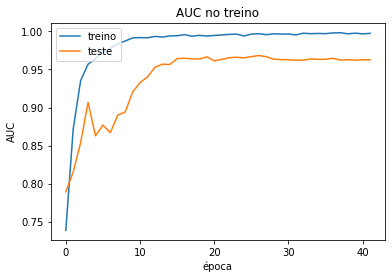

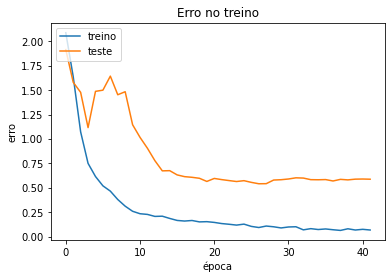

In [11]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC no treino')
plt.ylabel('AUC')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro no treino')
plt.ylabel('erro')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()


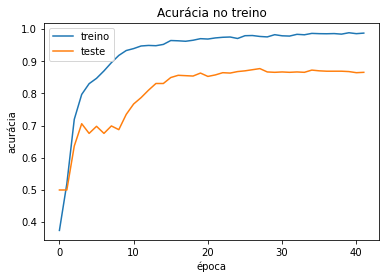

In [15]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Acurácia no treino')
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

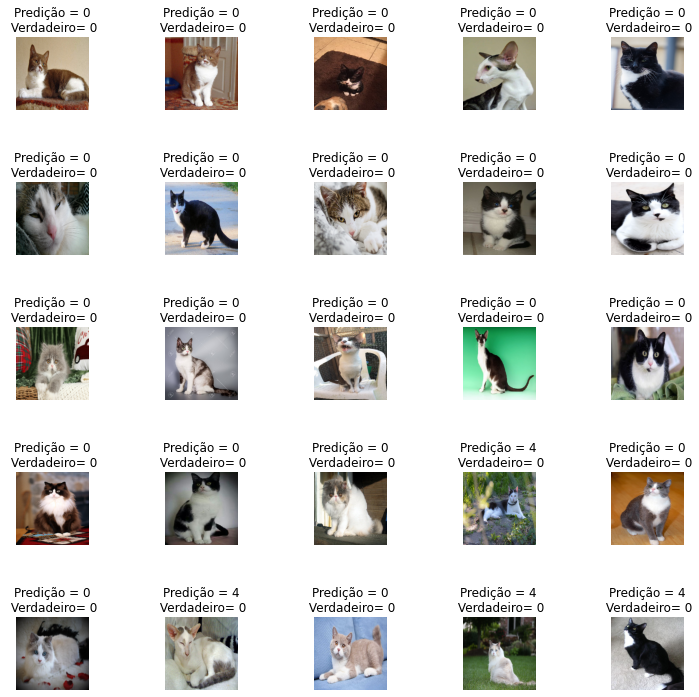

In [16]:
valid_gen.shuffle = False
valid_gen.index_array = None
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(valid_gen[0][0], batch_size=batch_size)
for i in np.arange(0,L*W):
    axes[i].imshow(valid_gen[0][0][i])
    axes[i].set_title('Predição = {}\n Verdadeiro= {}'.format(y_pred.argmax(axis=1)[i], valid_gen[0][1][i].argmax(axis=0)))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

In [19]:
y_pred0 = model.predict_generator(valid_gen, batch_size)
y_pred1 = np.argmax(y_pred0, axis=1)
print(classification_report(valid_gen.classes, y_pred1,target_names=['bicolor','calico','hairless','point_color','solid_color','tabby_classic','tabby_mackerel','tabby_spotted','tortoiseshell']))

                precision    recall  f1-score   support

       bicolor       0.82      0.86      0.84        63
        calico       0.90      0.91      0.91        68
      hairless       0.98      0.99      0.99       102
   point_color       0.95      0.95      0.95       118
   solid_color       0.93      0.94      0.93       295
 tabby_classic       0.60      0.82      0.69        50
tabby_mackerel       0.51      0.56      0.53        45
 tabby_spotted       0.90      0.71      0.79       103
 tortoiseshell       0.82      0.52      0.64        27

      accuracy                           0.87       871
     macro avg       0.82      0.81      0.81       871
  weighted avg       0.88      0.87      0.87       871



In [22]:
accuracy_score(valid_gen.classes,y_pred1)

0.8725602755453502

<AxesSubplot:>

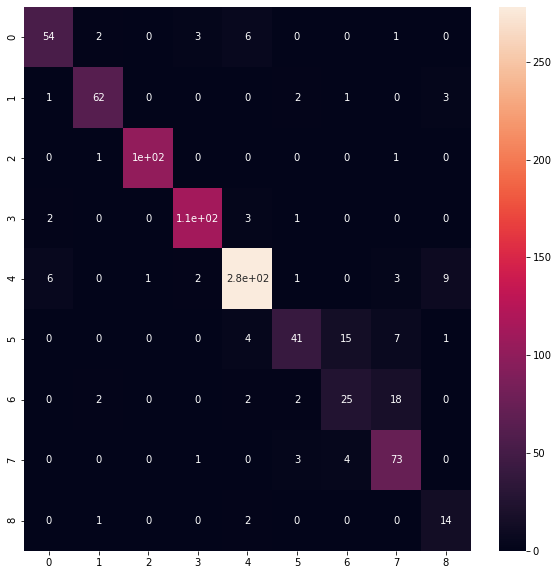

In [23]:
cm = confusion_matrix(y_pred1,valid_gen.classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

In [24]:
model.save('modelo_pelagem.h5')